In [2]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data (same as in your n-grams approach)
with open('translate/atomic_claims_FCGPT_claude_translated.json', 'r') as file:
    loki_translated = json.load(file)

with open('translate/translated.json', 'r') as file:
    dataset_translated = json.load(file)


In [11]:
# Process dataset to organize claims by comment (same as in your ROUGE implementation)
gt_comments = []
for entry in dataset_translated:
    claims = []
    for item in entry.get('claims', []):
        if isinstance(item, list):
            claims.extend(item)
        elif isinstance(item, dict):
            claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            claims.append(item)
    gt_comments.append(claims)

loki_comments = []
for entry in loki_translated:
    claims = []
    for item in entry.get('claims', []):
        if isinstance(item, list):
            claims.extend(item)
        elif isinstance(item, dict):
            claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            claims.append(item)
    loki_comments.append(claims)


print(f"Number of GT claims: {len(gt_comments)}")
print(f"Number of generated claims: {len(loki_comments)}")

Number of GT claims: 94
Number of generated claims: 93


In [12]:
# Function to compute normalized similarity from edit distance
def compute_edit_similarity(reference, candidate):
    # Get raw Levenshtein distance
    edit_distance = Levenshtein.distance(reference, candidate)

    # Normalize by the length of the longer string
    max_len = max(len(reference), len(candidate))
    if max_len == 0:  # Handle empty strings
        return 1.0

    # Convert to similarity (1 - normalized distance)
    similarity = 1 - (edit_distance / max_len)
    return similarity


In [14]:
# Comment-based evaluation
all_scores = []
all_pairs = []
comment_metrics = []
threshold = 0.7

for i, (gt_claims_comment, gen_claims_comment) in enumerate(zip(gt_comments, loki_comments)):
    # Skip empty comments
    if not gt_claims_comment or not gen_claims_comment:
        continue

    # Create similarity matrix for this comment
    num_gt = len(gt_claims_comment)
    num_gen = len(gen_claims_comment)

    # Handle unequal number of claims
    max_claims = max(num_gt, num_gen)
    similarity_matrix = np.zeros((max_claims, max_claims))

    # Fill similarity matrix (missing claims get 0 similarity)
    for i_idx in range(min(num_gt, max_claims)):
        for j_idx in range(min(num_gen, max_claims)):
            similarity_matrix[i_idx, j_idx] = compute_edit_similarity(gt_claims_comment[i_idx], gen_claims_comment[j_idx])

    # Apply Hungarian algorithm
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Get valid matches (ignoring padding)
    valid_matches = [(r, c) for r, c in zip(row_ind, col_ind)
                     if r < num_gt and c < num_gen]

    if not valid_matches:
        continue

    # Calculate metrics for this comment
    comment_scores = [similarity_matrix[r, c] for r, c in valid_matches]
    avg_score = np.mean(comment_scores)

    # Track matched pairs
    comment_pairs = [
        {
            'Comment_Index': i,
            'GT_Claim': gt_claims_comment[r],
            'Generated_Claim': gen_claims_comment[c],
            'Score': similarity_matrix[r, c]
        }
        for r, c in valid_matches
    ]

    # Calculate comment-level metrics
    good_matches = sum(1 for score in comment_scores if score >= threshold)
    recall = good_matches / num_gt if num_gt > 0 else 0
    precision = good_matches / num_gen if num_gen > 0 else 0

    # Add comment metrics
    comment_metrics.append({
        'Comment_Index': i,
        'Avg_Score': avg_score,
        'Recall': recall,
        'Precision': precision,
        'GT_Claims': num_gt,
        'Gen_Claims': num_gen,
        'Good_Matches': good_matches
    })

    # Add to overall scores and pairs
    all_scores.extend(comment_scores)
    all_pairs.extend(comment_pairs)

# Convert to DataFrame for easier analysis
df_metrics = pd.DataFrame(comment_metrics)

# Overall metrics
overall_avg_score = np.mean(all_scores)
overall_recall = np.mean(df_metrics['Recall'])
overall_precision = np.mean(df_metrics['Precision'])

print(f"Overall Average Score (Edit Distance): {overall_avg_score:.3f}")
print(f"Overall Recall (Edit Distance): {overall_recall:.2%}")
print(f"Overall Precision (Edit Distance): {overall_precision:.2%}")

Overall Average Score (Edit Distance): 0.569
Overall Recall (Edit Distance): 28.38%
Overall Precision (Edit Distance): 24.98%


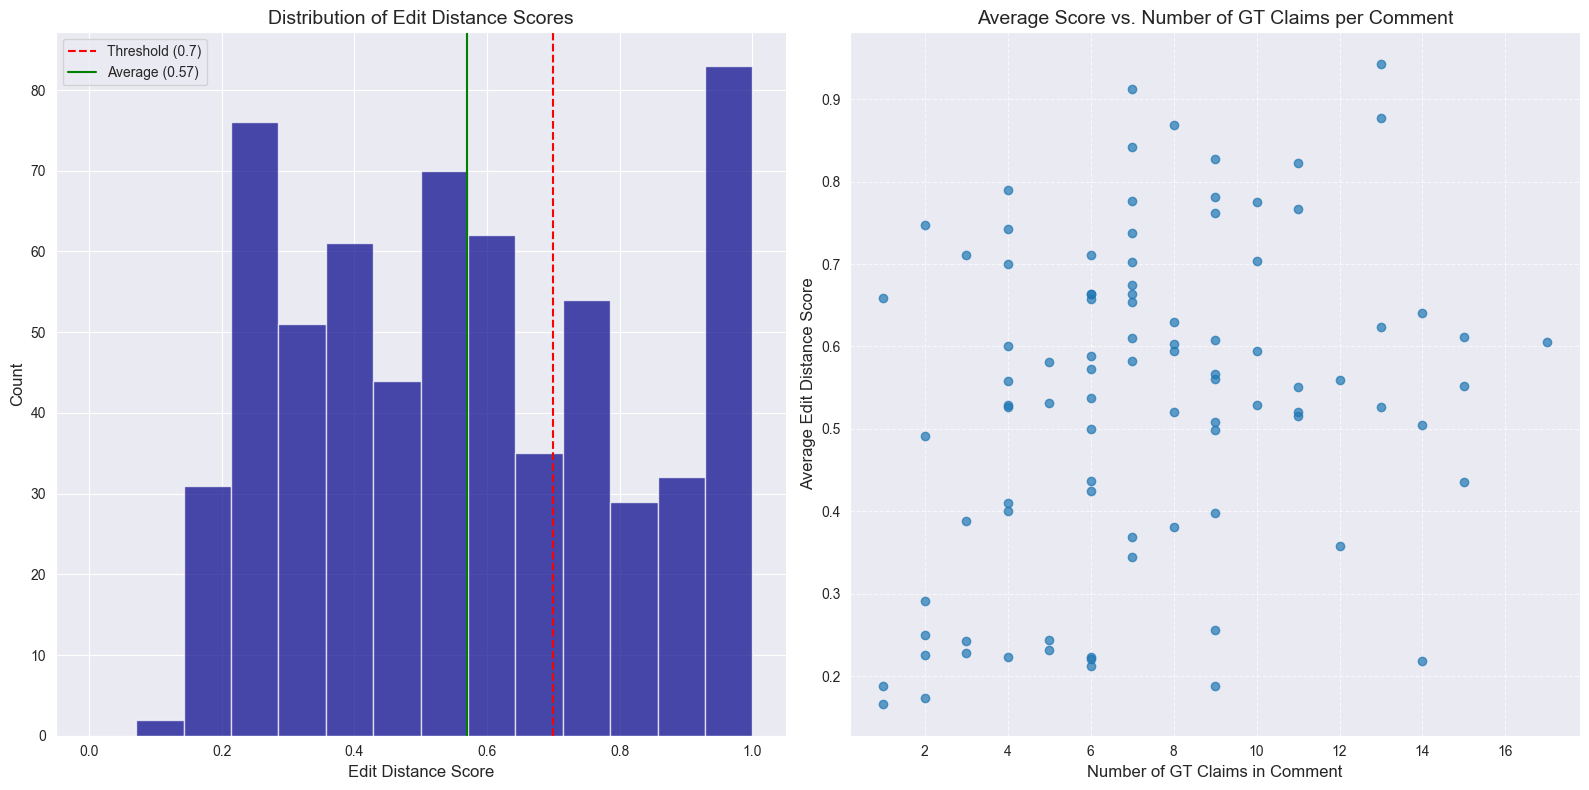

In [15]:
# Visualization
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Distribution of scores
bins = np.linspace(0, 1, 15)
ax1.hist(all_scores, bins=bins, color='darkblue', alpha=0.7)
ax1.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
ax1.axvline(x=overall_avg_score, color='green', linestyle='-', label=f'Average ({overall_avg_score:.2f})')
ax1.set_title('Distribution of Edit Distance Scores', fontsize=14)
ax1.set_xlabel('Edit Distance Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend()

# Per-comment metrics
ax2.scatter(df_metrics['GT_Claims'], df_metrics['Avg_Score'], alpha=0.7)
ax2.set_title('Average Score vs. Number of GT Claims per Comment', fontsize=14)
ax2.set_xlabel('Number of GT Claims in Comment', fontsize=12)
ax2.set_ylabel('Average Edit Distance Score', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()